In [1]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
import tqdm
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapz, cumtrapz
from schwimmbad import MultiPool
from utils import get_LISA_norm, get_LISA_norm_circular, dg_de
from scipy.interpolate import interp1d

In [2]:
def dN_dVdMdf(comoving_merger_rate, m_c, f):
    dt_df = 1/lw.utils.fn_dot(m_c=m_c, f_orb=f, n=2, e=np.zeros(f.shape))
    
    return comoving_merger_rate * dt_df
    
    
def ligo_rate_grid(M_c):
    rate = 23 * np.ones(len(M_c))
    rate[M_c > 20 * u.Msun] = 5
    rate[M_c > 50 * u.Msun] = 0.2
    
    return rate * u.Gpc**(-3) * u.yr**(-1)


def ligo_rate(m1):
    dat = np.array([[3.705799151343708, 0.001087789470121345],
                   [4.384724186704389, 0.00984816875074369],
                   [5.063649222065067, 0.06979974252228799],
                   [5.827439886845831, 0.41173514594201527],
                   [6.506364922206512, 1.3579705933006465],
                   [6.845827439886847, 2.148948034692836],
                   [7.77934936350778, 2.7449738151212433],
                   [8.543140028288544, 2.6218307403757986],
                   [9.561527581329564, 2.0525434471508692],
                   [11.173974540311175, 1.2388629239937763],
                   [12.701555869872706, 0.7828664968878465],
                   [14.398868458274404, 0.4947116747780942],
                   [16.859971711456865, 0.2895969742197884],
                   [19.66053748231967, 0.17748817964452962],
                   [22.206506364922213, 0.12773570001722281],
                   [24.837340876944843, 0.10389898279212807],
                   [27.722772277227726, 0.1087789470121345],
                   [30.183875530410184, 0.13070104796093673],
                   [32.729844413012735, 0.16441704701060267],
                   [34.85148514851486, 0.16695189854274867],
                   [37.397454031117405, 0.12107555776371784],
                   [39.26449787835927, 0.08010405199404155],
                   [41.30127298444131, 0.049851062445855264],
                   [43.592644978783596, 0.029631988560550687],
                   [45.629420084865636, 0.018440841322693136],
                   [48.0905233380481, 0.011832859313068754],
                   [50.891089108910904, 0.007949361111716631],
                   [53.77652050919379, 0.005764973856945108],
                   [57.25601131541727, 0.0043438393396653925],
                   [61.923620933521946, 0.0032730313574784275],
                   [66.67609618104669, 0.0024851284269805634],
                   [70.66478076379069, 0.002068305171949823],
                   [74.82319660537483, 0.0016952583040389245],
                   [78.72701555869875, 0.0013476220436441713],
                   [81.27298444130128, 0.0010389898279212807]])
    
    mass = dat[:,0]
    rate = dat[:,1]
    interp_rate = interp1d(mass, rate)
    
    return interp_rate(m1)
    

In [42]:
f = np.logspace(-1, -5, 100) * u.Hz
masses = np.linspace(5, 80, 200) * u.Msun
m_c = lw.utils.chirp_mass(masses, masses)
F, MASS = np.meshgrid(f, masses)

MC = lw.utils.chirp_mass(MASS, MASS)

RATE = ligo_rate(MASS.flatten().value)
RATE = RATE.reshape(MC.shape) * u.Gpc**(-3) * u.yr**(-1)

In [43]:
np.shape(F), np.shape(MC), np.shape(MASS)

((200, 100), (200, 100), (200, 100))

In [44]:
lisa_rate = dN_dVdMdf(RATE, MC, F)

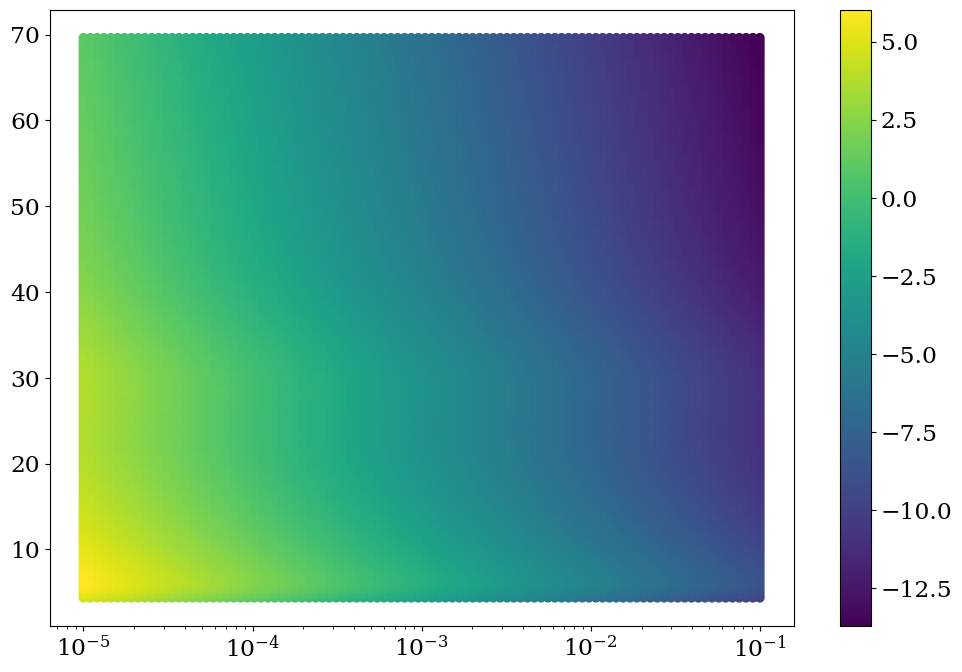

In [45]:
plt.scatter(F, MC, c=np.log10(lisa_rate.to(u.Mpc**(-3) * u.Hz**(-1)).value))
plt.xscale('log')
plt.colorbar()

In [46]:
source = lw.source.Source(m_1=MASS.flatten(),
                          m_2=MASS.flatten(),
                          ecc=np.zeros(len(F.flatten())),
                          f_orb=F.flatten(),
                          dist=8 * np.ones(len(F.flatten())) * u.Mpc,
                          interpolate_g=False,
                          n_proc=1)
snr = source.get_snr(approximate_R=True, verbose=True)
D_h = snr/7 * 8 * u.Mpc
redshift = np.ones(len(D_h)) * 1e-8
redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
V_c = Planck18.comoving_volume(z=redshift)


Calculating SNR for 20000 sources
	0 sources have already merged
	11569 sources are stationary
		11569 sources are stationary and circular
	8431 sources are evolving
		8431 sources are evolving and circular


In [47]:
V_c = V_c.reshape(F.shape)

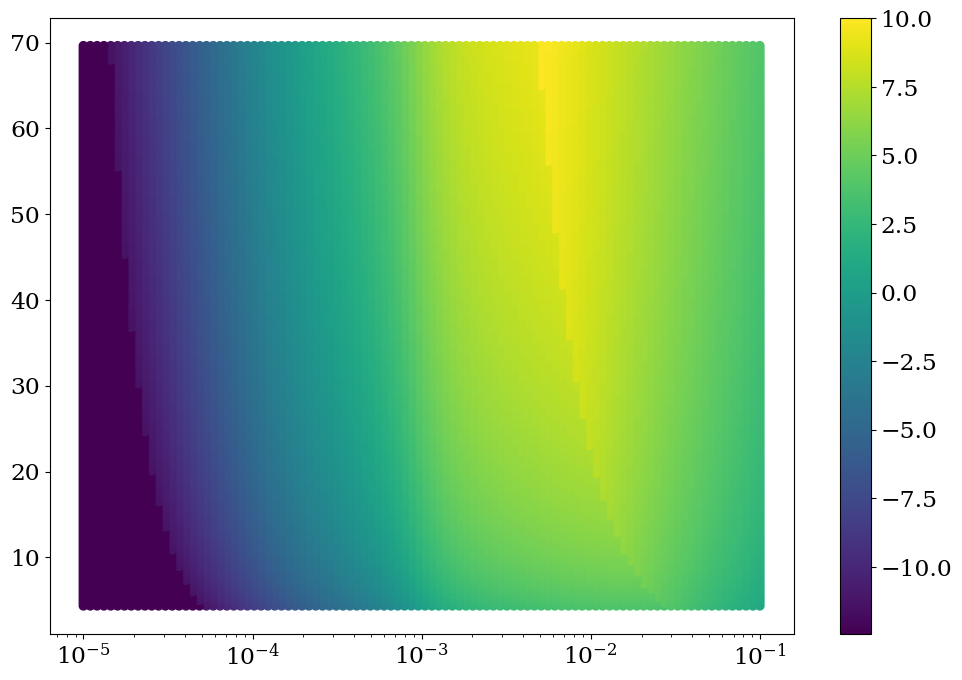

In [48]:
plt.scatter(F, MC, c=np.log10(V_c.to(u.Mpc**3).value))
plt.xscale('log')
plt.colorbar()

In [49]:
D_h = D_h.reshape(F.shape)

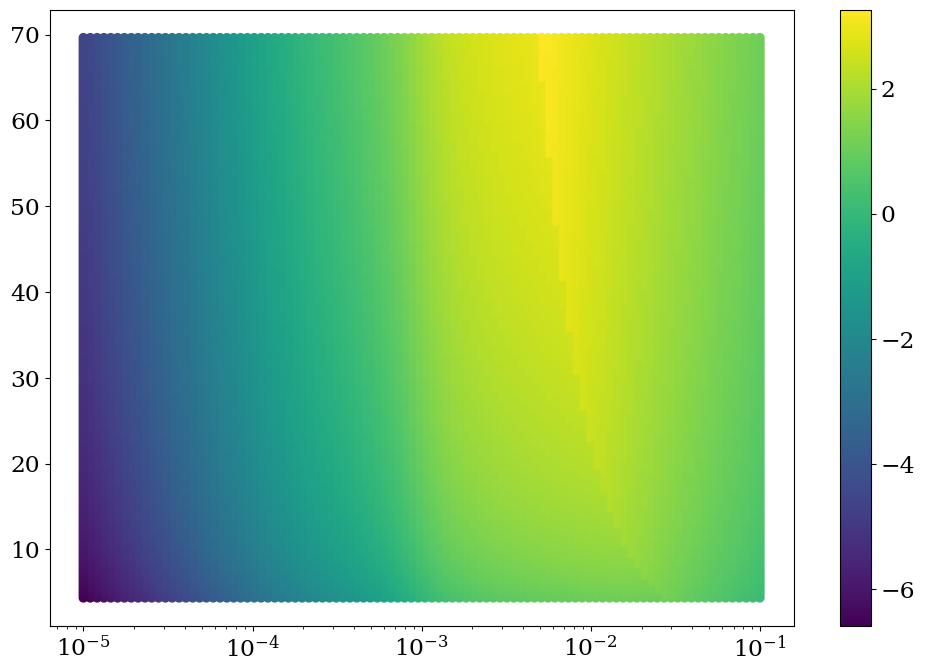

In [50]:
plt.scatter(F, MC, c=np.log10(D_h.to(u.Mpc).value))
plt.xscale('log')
plt.colorbar()

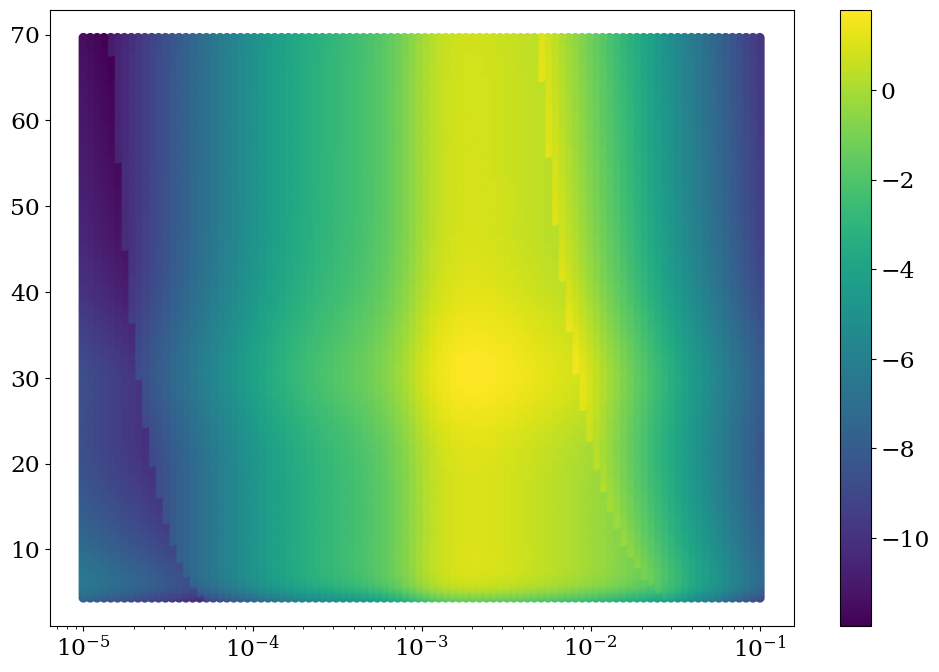

In [51]:
plt.scatter(F, MC, c=np.log10((V_c.to(u.Mpc**3) * lisa_rate.to(u.Mpc**(-3) * u.Hz**(-1))).value))
plt.xscale('log')
plt.colorbar()

In [52]:
n_dim_mass = len(masses)
F[0,:]

<Quantity [1.00000000e-01, 9.11162756e-02, 8.30217568e-02, 7.56463328e-02,
           6.89261210e-02, 6.28029144e-02, 5.72236766e-02, 5.21400829e-02,
           4.75081016e-02, 4.32876128e-02, 3.94420606e-02, 3.59381366e-02,
           3.27454916e-02, 2.98364724e-02, 2.71858824e-02, 2.47707636e-02,
           2.25701972e-02, 2.05651231e-02, 1.87381742e-02, 1.70735265e-02,
           1.55567614e-02, 1.41747416e-02, 1.29154967e-02, 1.17681195e-02,
           1.07226722e-02, 9.77009957e-03, 8.90215085e-03, 8.11130831e-03,
           7.39072203e-03, 6.73415066e-03, 6.13590727e-03, 5.59081018e-03,
           5.09413801e-03, 4.64158883e-03, 4.22924287e-03, 3.85352859e-03,
           3.51119173e-03, 3.19926714e-03, 2.91505306e-03, 2.65608778e-03,
           2.42012826e-03, 2.20513074e-03, 2.00923300e-03, 1.83073828e-03,
           1.66810054e-03, 1.51991108e-03, 1.38488637e-03, 1.26185688e-03,
           1.14975700e-03, 1.04761575e-03, 9.54548457e-04, 8.69749003e-04,
           7.92482898e-04

In [53]:
rate_per_mass = []
for ii in range(n_dim_mass):
    rate_int = V_c[ii,:].to(u.Mpc**3) * lisa_rate[ii,:].to(u.Mpc**(-3) * u.Hz**(-1))
    f_int = F[ii,:]
    
    rate_per_mass.append(trapz(rate_int, -f_int).value)
                                                       

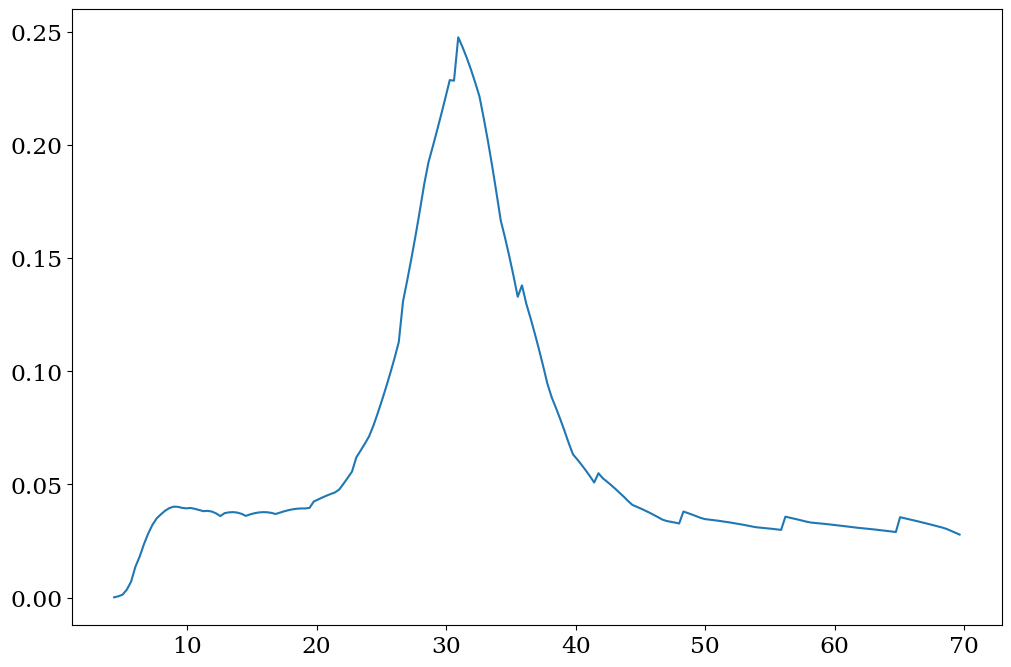

In [54]:
plt.plot(m_c, rate_per_mass)

In [55]:
N_LISA = trapz(rate_per_mass, m_c.value)

In [56]:
N_LISA

4.2024741576324836

## Ok -- so this is the rate assuming q=1; that's basically the most optimistic case that we could imagine based on the LIGO rates for circular only binaries.

## I think the next step is to get the eccentric tool to do this for q=1, then extend out to q=!1


In [36]:
mc = [ 4.35275282,  5.68522817,   7.01770352,  8.35017887,  9.68265422, 11.01512958,
 12.34760493, 13.68008028,  15.01255563, 16.34503098, 17.67750634, 19.00998169,
 20.34245704, 21.67493239,  23.00740774, 24.3398831 , 25.67235845, 27.0048338,
 28.33730915, 29.6697845 ,  31.00225986, 32.33473521, 33.66721056, 34.99968591,
 36.33216126, 37.66463662,  38.99711197, 40.32958732, 41.66206267, 42.99453802,
 44.32701338, 45.65948873,  46.99196408, 48.32443943, 49.65691478, 50.98939014,
 52.32186549, 53.65434084,  54.98681619, 56.31929154, 57.6517669 , 58.98424225,
 60.3167176 , 61.64919295,  62.9816683 , 64.31414366, 65.64661901, 66.97909436,
 68.31156971, 69.64404506]

In [37]:
rate = [0.00013852476601355885, 0.00742996576373261, 0.028678948219863453, 0.03859734825055809, 0.03927926341760355, 0.0381875406322966, 0.03678734675037602, 0.03772050672008571, 0.037033119714213705, 0.03759426518691027, 0.038432255417833606, 0.039411446512983776, 0.04400432380280183, 0.0472986772464044, 0.06154289522174669, 0.07540225957523031, 0.09906720981714509, 0.14072709588019336, 0.1840219623184469, 0.21484552659934078, 0.2467408609023587, 0.22593345501706294, 0.18665424924297777, 0.1474730650545128, 0.1270799698821705, 0.09821108708121197, 0.07591567069667168, 0.05958321179688291, 0.05601768111732853, 0.04843499864219883, 0.04108262249109828, 0.0376561211911344, 0.03388241779897346, 0.038038992352287554, 0.03524796047296924, 0.03400046403950433, 0.03283508766765501, 0.03141709136630799, 0.030510010184747815, 0.03561316024997353, 0.03383813532552814, 0.032747712042401914, 0.031892937416821275, 0.030948944155462964, 0.030171241469123842, 0.029286462879931387, 0.034769869464085945, 0.03295573924926246, 0.030977584616467945, 0.02786907308091234]

In [38]:
interp_rate = interp1d(mc, rate)

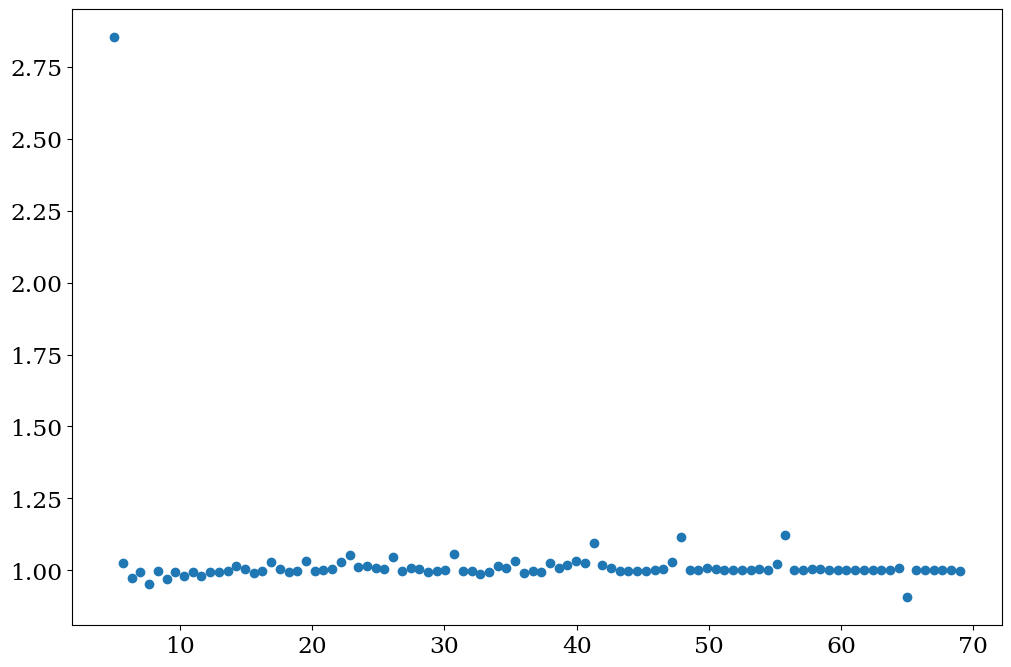

In [39]:
ind_check, = np.where((m_c.value > min(mc)) & (m_c.value < max(mc)))
plt.scatter(m_c[ind_check], interp_rate(m_c[ind_check])/np.array(rate_per_mass)[ind_check])

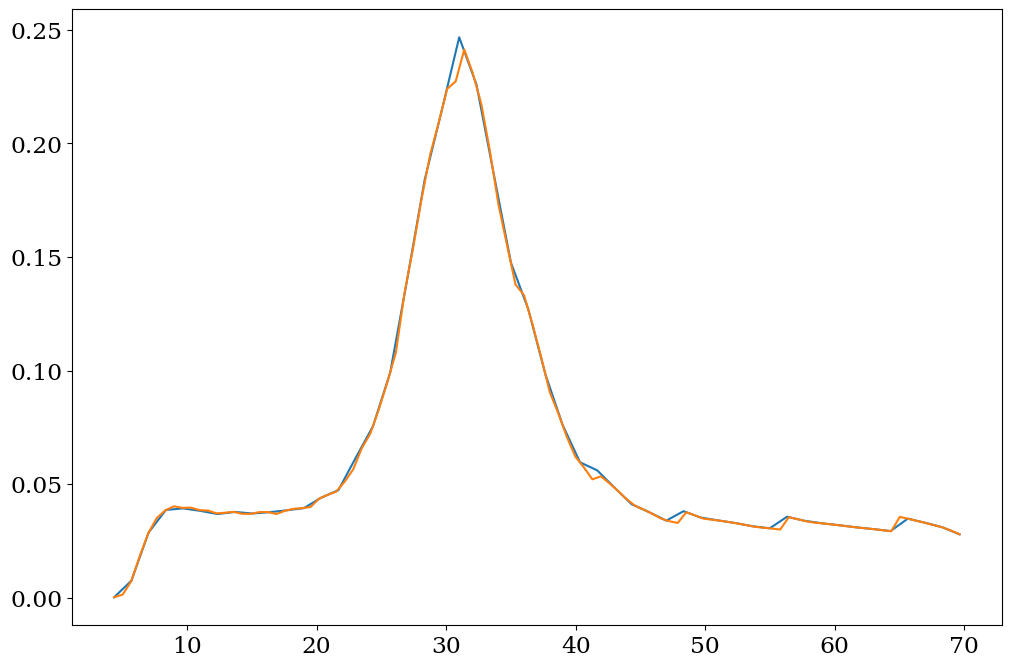

In [40]:
plt.plot(mc, rate)
plt.plot(m_c, rate_per_mass)